In [325]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize



from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, TextVectorization, Bidirectional
from tensorflow.keras.layers import Embedding, GRU, LSTM, Dropout
from tensorflow.keras.initializers import Constant 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical

In [326]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Project Topic

This notebook is about building a machine learning model that predicts which tweets are about real disaster and which are not. It is a a good starter for NLP. I will be using simple RNN model and LSTM model to demonstrate what was taught in class and compare the result

# Data 

The dataset contained 10,000 tweets that were hand classified. The dataset have 5 columns; id, keyword, location, text and target.

In [327]:
sub_df = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')


In [328]:
print(train_df.head())
print(test_df.head())
print(sub_df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
   id  target
0   0  

In [329]:
print(train_df.columns)
print(train_df.describe)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
<bound method NDFrame.describe of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse

# Exploratory Data Analysis 

Does it include a word count, some histograms, a few other visualizations, etc.? 

0    4342
1    3271
Name: target, dtype: int64


(array([4342.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3271.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

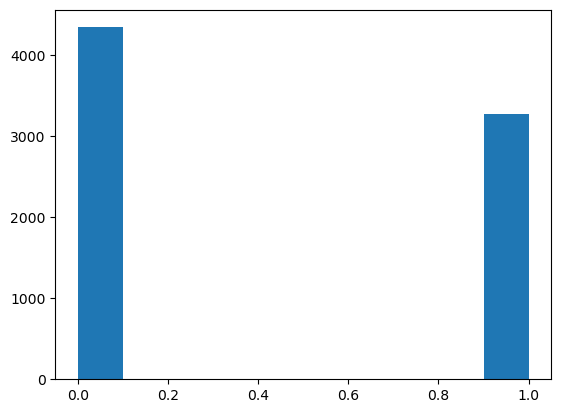

In [330]:
print(train_df['target'].value_counts())
plt.hist(train_df['target'])

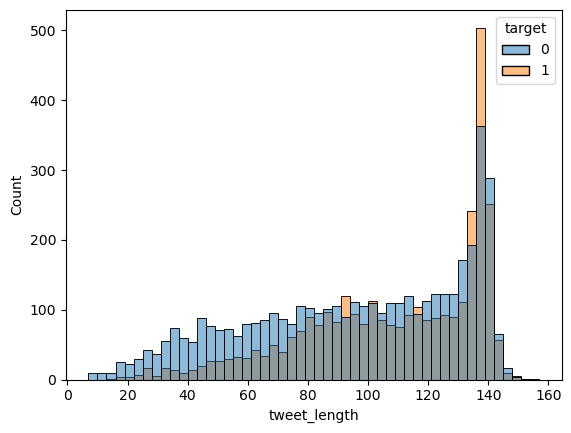

In [331]:
train_df['tweet_length'] = train_df['text'].str.len()

sns.histplot(data=train_df, x='tweet_length', hue='target', fill=True, bins = 50)
plt.show()

# Data Cleaning

Remove stop word from text

In [334]:
def dataclean(text):
    stop_words = set(stopwords.words('english'))
  
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
  
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    
    return filtered_sentence


train_df['cleaned'] = train_df['text'].apply(dataclean)

In [336]:
print(train_df['cleaned'][0:10])

0    ['Our', 'Deeds', 'Reason', '#', 'earthquake', ...
1    ['Forest', 'fire', 'near', 'La', 'Ronge', 'Sas...
2    ['All', 'residents', 'asked', "'shelter", 'pla...
3    ['13,000', 'people', 'receive', '#', 'wildfire...
4    ['Just', 'got', 'sent', 'photo', 'Ruby', '#', ...
5    ['#', 'RockyFire', 'Update', '=', '>', 'Califo...
6    ['#', 'flood', '#', 'disaster', 'Heavy', 'rain...
7    ['I', "'m", 'top', 'hill', 'I', 'see', 'fire',...
8    ['There', "'s", 'emergency', 'evacuation', 'ha...
9    ['I', "'m", 'afraid', 'tornado', 'coming', 'ar...
Name: cleaned, dtype: object


# Plan of Analysis based on EDA 

We need to tokenize the text and pad the sequences for the neural networks

In [324]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_df['text'])

max_tweet = max(len(x.split()) for x in train_df['text'])
print('Tweet Length : ', max_tweet)

train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded = pad_sequences(Train_Sequences, maxlen=max_tweet)


X_train, X_test, y_train, y_test = train_test_split(train_padded, train_df['target'].values, test_size = 0.3, random_state = 0)

# This is used for Embedding layer afterwards
total_words = len(tokenizer.word_index) + 1
print(Train_Word_Count)

print(X_train.shape)
print(y_train.shape)

Tweet Length :  31
22701
(5329, 31)
(5329,)


# Model Architecture

In [297]:
# Model constant
INPUT_LENGTH = max_tweet
HIDDEN_UNITS = 128
EMBED_UNITS = 10
EPOCHS = 8
BATCH_SIZE = 512


### Simple RNN Model

In [298]:
# Simple RNN 
rnn = Sequential()
rnn.add(Embedding(Train_Word_Count, EMBED_UNITS, input_length = INPUT_LENGTH))
rnn.add(SimpleRNN(units=HIDDEN_UNITS))
rnn.add(Dense(1, activation="sigmoid"))

rnn.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 31, 10)            227010    
                                                                 
 simple_rnn_45 (SimpleRNN)   (None, 128)               17792     
                                                                 
 dense_42 (Dense)            (None, 1)                 129       
                                                                 
Total params: 244,931
Trainable params: 244,931
Non-trainable params: 0
_________________________________________________________________


In [299]:
rnn.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [300]:
rnn_history = rnn.fit(X_train, y_train, 
                          shuffle = True,
                          validation_split=0.2,
                          batch_size = BATCH_SIZE, 
                          epochs = EPOCHS 
                          )

Epoch 1/8
9/9 [==============================] - 2s 90ms/step - loss: 0.6827 - accuracy: 0.5562 - val_loss: 0.6680 - val_accuracy: 0.6201
Epoch 2/8
9/9 [==============================] - 0s 55ms/step - loss: 0.6338 - accuracy: 0.6667 - val_loss: 0.6359 - val_accuracy: 0.6632
Epoch 3/8
9/9 [==============================] - 1s 56ms/step - loss: 0.5207 - accuracy: 0.7701 - val_loss: 0.6606 - val_accuracy: 0.6229
Epoch 4/8
9/9 [==============================] - 0s 52ms/step - loss: 0.4406 - accuracy: 0.7933 - val_loss: 0.7396 - val_accuracy: 0.5854
Epoch 5/8
9/9 [==============================] - 0s 54ms/step - loss: 0.3438 - accuracy: 0.8761 - val_loss: 0.6689 - val_accuracy: 0.6660
Epoch 6/8
9/9 [==============================] - 0s 53ms/step - loss: 0.2495 - accuracy: 0.9167 - val_loss: 0.8477 - val_accuracy: 0.5497
Epoch 7/8
9/9 [==============================] - 0s 54ms/step - loss: 0.1938 - accuracy: 0.9360 - val_loss: 0.7390 - val_accuracy: 0.6707
Epoch 8/8
9/9 [===================

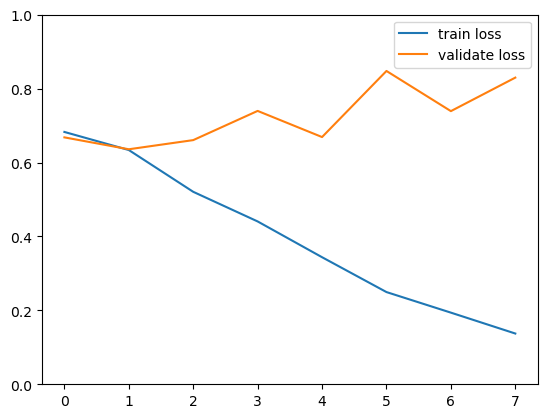

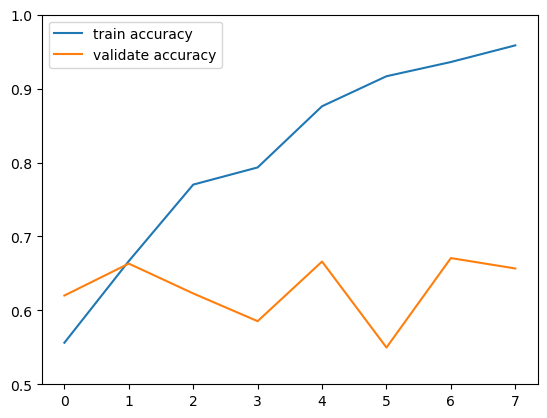

<Figure size 640x480 with 0 Axes>

In [301]:
plt.plot(rnn_history.history['loss'], label='train loss')
plt.plot(rnn_history.history['val_loss'], label='validate loss')
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()
plt.savefig('Loss_Comparison')


plt.plot(rnn_history.history['accuracy'], label='train accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='validate accuracy')
plt.ylim(0.5, 1.0)
plt.legend()
plt.show()
plt.savefig('Accuracy_Comparison')

### Simple LSTM Model

In [283]:
# LSTM Model

lstm = Sequential()
lstm.add(Embedding(Train_Word_Count, EMBED_UNITS, input_length = INPUT_LENGTH))
lstm.add(LSTM(units=HIDDEN_UNITS))
#lstm.add(Dense(64, activation='relu'))
#lstm.add(Dropout(0.1))
lstm.add(Dense(1, activation='sigmoid'))
Optimizer1 = Adam(learning_rate=0.001)

lstm.summary()


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 31, 10)            227010    
                                                                 
 lstm_11 (LSTM)              (None, 128)               71168     
                                                                 
 dense_41 (Dense)            (None, 1)                 129       
                                                                 
Total params: 298,307
Trainable params: 298,307
Non-trainable params: 0
_________________________________________________________________


In [284]:
lstm.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [285]:
lstm_history = lstm.fit(X_train, y_train, 
                          shuffle = True,
                          validation_split=0.2,
                          batch_size = batch_size, 
                          epochs = Epoch_Count 
                          )

Epoch 1/8
9/9 [==============================] - 5s 242ms/step - loss: 0.6882 - accuracy: 0.5536 - val_loss: 0.6764 - val_accuracy: 0.5750
Epoch 2/8
9/9 [==============================] - 2s 176ms/step - loss: 0.6758 - accuracy: 0.5609 - val_loss: 0.6626 - val_accuracy: 0.5750
Epoch 3/8
9/9 [==============================] - 2s 172ms/step - loss: 0.6378 - accuracy: 0.6425 - val_loss: 0.6120 - val_accuracy: 0.6773
Epoch 4/8
9/9 [==============================] - 2s 181ms/step - loss: 0.5783 - accuracy: 0.7211 - val_loss: 0.5802 - val_accuracy: 0.7120
Epoch 5/8
9/9 [==============================] - 2s 201ms/step - loss: 0.4950 - accuracy: 0.8114 - val_loss: 0.5339 - val_accuracy: 0.7467
Epoch 6/8
9/9 [==============================] - 2s 177ms/step - loss: 0.3727 - accuracy: 0.8543 - val_loss: 0.5607 - val_accuracy: 0.7664
Epoch 7/8
9/9 [==============================] - 2s 173ms/step - loss: 0.2712 - accuracy: 0.9008 - val_loss: 0.5499 - val_accuracy: 0.7589
Epoch 8/8
9/9 [============

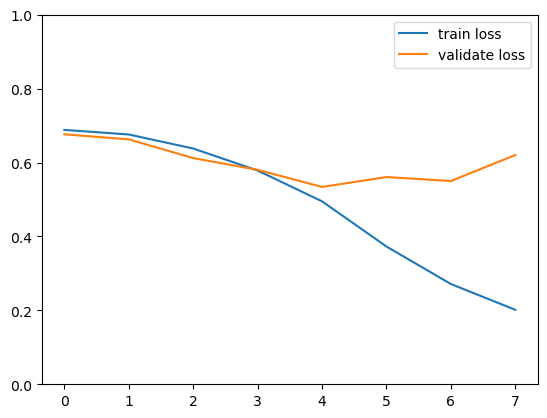

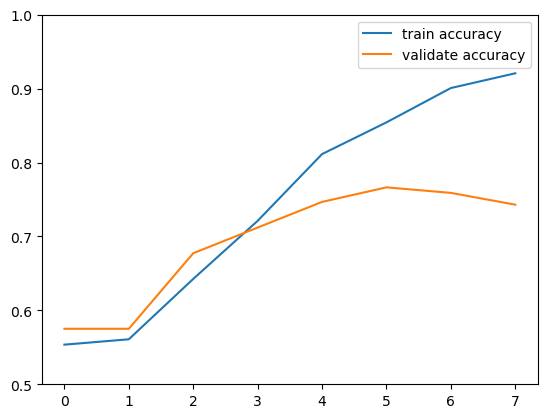

<Figure size 640x480 with 0 Axes>

In [286]:
plt.plot(lstm_history.history['loss'], label='train loss')
plt.plot(lstm_history.history['val_loss'], label='validate loss')
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()
plt.savefig('Loss_Comparison')


plt.plot(lstm_history.history['accuracy'], label='train accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='validate accuracy')
plt.ylim(0.5, 1.0)
plt.legend()
plt.show()
plt.savefig('Accuracy_Comparison')

# Results and Analysis 

One thing that really stand out was how fast the training model become overfitted. From the graphs, the rnn model become over fitted after 1st epoch, and lstm model is just about to be overfitted after epoch 6. One thing to point out is the simplicity of the model. Both neural network only have 1 hidden layer, one with simple rnn and another with lstm. I think for this case, it shows that lstm work better

# Conclusion 



In this project, using a more recent advanced neural network models can improve the accuracy. We went from an intial accuracy of 60 percent to one that scored 75% by changing the hidden layer from rnn to lstm. Again this are just very simple model, there are more types of layer that can be added to the mix, such as cnn and max pooling layer. With different combinations of layer, I'm sure it will yield better result. 


# Submission

In [275]:
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded = pad_sequences(test_sequences, maxlen=max_tweet)

In [276]:
lstm_predict = lstm.predict(test_padded)


102/102 [==============================] - 2s 14ms/step


In [277]:

sub_df['target'] = np.round(lstm_predict).astype(int)

sub_df.to_csv('submission.csv', index=False)